# RRFS Data

The Rapid Refresh Forecast System (RRFS) is undergoing rapid development. There are prototype products available on the cloud on AWS. Some files have an index file, others do not.

## **1 - Start here!**

This cell will install conda, which will allow us to install newer versions of some packages we need than pip alone on Google Colab. Run it by mousing over it and clicking the play button that appears on the left side. It will restart the notebook when it finishes, which will make a popup in the lower left corner saying the notebook crashed. It did not, we restarted it! You can close that and move on when it happens.

In [2]:
!pip install ecmwflibs
!pip install eccodes
!pip install pygrib
!pip install cartopy contextily pyproj pyepsg netCDF4 xarray pygrib

import os
import pandas as pd
import pygrib
import numpy as np
import numpy.ma as ma
import os
from urllib.request import urlretrieve

import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.axes as maxes
import matplotlib.patheffects as PathEffects
from matplotlib.path import Path
from matplotlib.textpath import TextToPath
from matplotlib.font_manager import FontProperties
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.transforms import Bbox
#from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline


from pyproj.crs import CRS

from datetime import datetime, timedelta

from cartopy import cartopy, crs as ccrs, feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import contextily as cx
from scipy.ndimage.filters import gaussian_filter

import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 MB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for findlibs: filename=findlibs-0.0.5-py3-none-any.whl size=6941 sha256=369e56bb76efd36181ea1c6508138e688e9ccadda7b11587e7fb904964ece282
  Stored in directory: /root/.cache/pip/wheels/2e/67/14/22fa5b9fd9c41be520b37e908597d6a262803c0fcf2ba7c2c3
Successfully built findlibs
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eccodes: filename=eccodes-1.7.0-py3-none-any.whl size=41293 sha256=306e923b81c4298db6b31ba9daa5fd04954f994a238fde55bd9b912731dfecd4
  Stored in directory: /root/.cache/pip/wheels/44/16/96/7b9c3092abbd09c79444ba34e07106bc0992eb1c9e05fd58f3
Successfully built eccodes
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

<ipython-input-2-8184aa81ee98>:38: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


## **2 - Install and import**

This cell will usually take a minute or two to run. It will install and import all the python packages we need.

In [ ]:
# This installs and imports all the python packages/modules we need and will use later
!mamba install -q -c conda-forge cartopy contextily pyepsg pyproj pygrib netCDF4
import numpy as np
import os
from urllib.request import urlretrieve

import matplotlib
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.axes as maxes
import matplotlib.patheffects as PathEffects
from matplotlib.path import Path
from matplotlib.textpath import TextToPath
from matplotlib.font_manager import FontProperties
matplotlib.rcParams['font.sans-serif'] = 'Liberation Sans'
matplotlib.rcParams['font.family'] = "sans-serif"
from cartopy import cartopy, crs as ccrs, feature as cfeature

import xarray as xr
import pygrib
import netCDF4 as nc
import pandas as pd
import json
import requests
from pyproj.crs import CRS

from datetime import datetime, timedelta
import contextily as cx

import warnings
warnings.filterwarnings("ignore")

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


/usr/local/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


## **3 - Set options and go!**

Set all your options in the form below and go!

This is currently hard-coded to the 06UTC model run, with forecast hour=18, resulting in a map valid at 00UTC

In [17]:
#################### FORM STUFF HERE ###################################################################################
#@title Plot Config { vertical-output: true, form-width: "50%", display-mode: "form" }
#@markdown Which Initialization Date?
init_date = "2024-05-09" #@param {type:"date"}
init_date = datetime.strptime(init_date,'%Y-%m-%d')
init_strftime = init_date.strftime('%Y%m%d')
print(init_strftime)
#init_cyc = "06" #@param {type:"date"}
init_cyc = "06"
init_cyc = datetime.strptime(init_cyc,'%H')
init_strfcyc = init_cyc.strftime('%H')
print(init_strfcyc)
#init_fhr = "18" #@param {type:"date"}
init_fhr = "16"
init_fhr = datetime.strptime(init_fhr,'%H')
init_strfhr = init_fhr.strftime('%H')
print(init_strfhr)





20240509
06
16


Sets the AWS GRIB file to download


In [24]:
# AWS Direct URL
#url = f"https://noaa-rrfs-pds.s3.amazonaws.com/rrfs_a/rrfs_a.20230403/17/rrfs.t17z.natlev.f015.conus_3km.grib2"
#  https://noaa-hrrr-bdp-pds.s3.amazonaws.com/hrrr.20220201/conus/hrrr.t12z.wrfsfcf36.grib2
#print(url)

url2 = f"https://noaa-rrfs-pds.s3.amazonaws.com/rrfs_a/rrfs_a." + init_strftime+ "/" + init_strfcyc + "/control/rrfs.t" + init_strfcyc + "z.testbed.f0" + init_strfhr + ".grib2"
print(url2)

https://noaa-rrfs-pds.s3.amazonaws.com/rrfs_a/rrfs_a.20240509/06/control/rrfs.t06z.testbed.f016.grib2


In [36]:
#################### FORM STUFF HERE ###################################################################################

day = "1"
#orig valid_date = init_date + timedelta(hours = 12, days = int(day))
#valid_date = init_date + timedelta(hours = 'str(init_fhr)', days = int(day))
valid_date = init_date + timedelta(hours = 18, days = int(day))
#orig valid_date_start = valid_date - timedelta(hours = 24)
valid_date_start = valid_date - timedelta(hours = 0)
valid_strftime = valid_date.strftime('%HZ %m-%d-%Y')

hazard = "Severe"

severe_hazard = "TOR"

#@markdown What map domain?
dom = "TXOK" #@param ["Custom", "CONUS", "ECONUS", "---- WESTERN REGION ----", "WR","NR","UT","AZ","SWUS","PNW", "---- CENTRAL REGION ----","CR", "NP", "GL", "CUS", "CO", "---- SOUTHERN REGION ----", "SR", "TXOK", "SE", "---- EASTERN REGION ----", "ER", "NE"]

#@markdown Pick a map theme
map_theme = "ESRI Dark Grey" #@param ["Light Shaded Relief", "Stamen Toner Light", "Positron", "Dark Matter", "Dark Grey Matter", "ESRI Light Grey", "ESRI Dark Grey"]
if "Dark" in map_theme:
  font_color='w'
  face_color='#272727'
else:
  font_color = 'k'
  face_color = 'w'
#@markdown Set the map scale offset from default (i.e. a 1 would scale up one level [make labels bigger])
map_scale_offset = "1" #@param ["-2","-1", "0", "1","2"]
map_zoom_offset = int(map_scale_offset)

#@markdown ### <b> Do you want LSRs?</b>
lsr_opt = False #@param {type:"boolean"}

#@markdown ### <b> Do you want CWA boundaries?</b>
cwa_opt = True #@param {type:"boolean"}

#@markdown ### <b> Do you want county boundaries?</b>
county_opt = True #@param {type:"boolean"}

pp_verif = False

lsr_opt = False
heavy_rain_threshold =  1.0

s4ariffg = False
#@markdown Enter custom lat/lon bounding box if custom was selected
custom_bottom_lat =  29.4284 #@param {type:"number"}
custom_left_lon = -105.811 #@param {type:"number"}
custom_top_lat =  40.7025#@param {type:"number"}
custom_right_lon = -88.8568 #@param {type:"number"}

#@markdown Enter a custom name if you want (mainly used for filename)
custom_name = "RRFS" #@param {type:"string"}

day1_elements = ["NSSL1", "NSSL2", "NSSL3", "NSSL4", "NSSL5", "HRRR", "HRRR2", "BLEND"]

if hazard == "ERO" and int(day) > 1 and ero_version in day1_elements:
  print("Selected ERO product is only available on Day 1. Fixing this for you this time, but next time, try to be more careful!")
  day = "1"
else:
  pass

if hazard == "Severe" and int(day) > 3:
  print("Hey now, severe outlooks in this notebook are only available out to day 3 (if you know where the days 4+ gribs are, lemme know). Setting it back to day 3 for you.")
  day = "3"
else:
  pass

# set up some global variables here
#proj = ccrs.epsg(3857)
proj = ccrs.Mercator.GOOGLE
latloncrs = ccrs.PlateCarree()

# Setup a domain dictionary to make things a bit easier
# Zoom offset will be the integeter subtracted from the calculated zoom scale for map tiles
# Legend is the legend location: 0=best, 1=UR, 2=UL, 3=LL, 4=LR, 5=R, 6=CL, 7=CR, 8=LC, 9=UC, 10=C

domain_dict = {"Custom":{"west":custom_left_lon,
                        "south":custom_bottom_lat,
                        "east":custom_right_lon,
                        "north":custom_top_lat,
                        "zoom_adj": map_zoom_offset,
                        "legend":3},

               "CONUS":{"west":-125.650,
                    "south":23.377,
                    "east":--66.488,
                    "north":50.924,
                    "zoom_adj": 0,
                    "legend":4},

               "ECONUS":{"west":-104.36,
                    "south":24.735,
                    "east":-66.453,
                    "north":49.755,
                    "zoom_adj": 0,
                    "legend":4},

               "WR":{"west":-126.917,
                    "south":30.586,
                    "east":-102.740,
                    "north":49.755,
                    "zoom_adj": 1,
                     "legend":4},

               "UT":{"west":-117.02,
                      "east":-106.92,
                      "north":42.13,
                      "south":36.80,
                      "zoom_adj": 1,
                     "legend":4},

               "NR":{"west":-117.5177,
                    "south":41.9071,
                    "east":-103.38071,
                    "north":49.3085,
                    "zoom_adj": 1,
                    "legend":4},

               "PNW":{"west":-125.4510,
                    "south":41.8754,
                    "east":-110.9318,
                    "north":49.5767,
                    "zoom_adj": 0,
                    "legend":4},

               "SWUS":{"west":-125.582,
                    "south":31.136,
                    "east":-108.689,
                    "north":42.859,
                    "zoom_adj": 0,
                    "legend":3},

               "AZ":{"west":-115.596,
                    "south":31.113,
                    "east":-107.887,
                    "north":37.446,
                    "zoom_adj": 0,
                    "legend":4},

               "CR":{"west":-111.534,
                    "south":35.118,
                    "east":-82.263,
                    "north":49.755,
                    "zoom_adj": 1,
                    "legend":1},

               "NP":{"west":-105.244,
                    "south":42.173,
                    "east":-89.426,
                    "north":49.474,
                    "zoom_adj": 1,
                    "legend":4},

               "GL":{"west":-97.606,
                    "south":38.735,
                    "east":-74.916,
                    "north":49.292,
                    "zoom_adj": 1,
                    "legend":3},

               "CUS":{"west":-111.553,
                    "south":34.794,
                    "east":-88.533,
                    "north":46.357,
                    "zoom_adj": 1,
                    "legend":3},

               "CO":{"west":-109.2934,
                    "south":36.8186,
                    "east":-101.8524,
                    "north":47.35,
                    "zoom_adj": 1,
                    "legend":4},

               "SR":{"west":-109.758,
                    "south":23.313,
                    "east":-78.247,
                    "north":37.899,
                    "zoom_adj": 1,
                    "legend":3},

               "TXOK":{"west":-106.95,
                    "south":26.06,
                    "east":-86.76,
                    "north":37.76,
                    "zoom_adj": 0,
                    "legend":4},

               "SE":{"west":-92.974,
                    "south":24.578,
                    "east":-75.1311,
                    "north":37.390,
                    "zoom_adj": 0,
                    "legend":4},

               "ER":{"west":-85.629,
                    "south":31.723,
                    "east":-66.465,
                    "north":47.676,
                    "zoom_adj": 0,
                    "legend":4},

               "NE":{"west":-85.629,
                    "south":37.654,
                    "east":-66.00,
                    "north":47.825,
                    "zoom_adj": 1,
                    "legend":4},

               "CONUS":{"west":-125.650,
                    "south":23.377,
                    "east":-66.488,
                    "north":50.924,
                    "zoom_adj": 0,
                    "legend":4},

               "ECONUS":{"west":-104.36,
                    "south":24.735,
                    "east":-66.453,
                    "north":49.755,
                    "zoom_adj": 0,
                    "legend":4},

}

west = domain_dict[dom]["west"]
south = domain_dict[dom]["south"]
east = domain_dict[dom]["east"]
north = domain_dict[dom]["north"]
map_zoom_offset = domain_dict[dom]["zoom_adj"]
LLOC = domain_dict[dom]["legend"]


# Set up the URL
#url_base = "http://schumacher.atmos.colostate.edu/gherman/ffair/"
#if hazard == "ERO":
#  file = f'EXQPF_DAY{day}_{ero_version_dict[ero_version]}_{init_strftime}.grib2'
#elif hazard == "Severe":
#  if int(day) > 1:
#    file = f'SEVERE_DAY{day}_PROBS_V1P1_GEFSO_{init_strftime}.grib2'
#  elif day == "1":
#    file = f'{severe_hazard}_DAY{day}_PROBS_V1P1_GEFSO_{init_strftime}_STD.grib2'
#url = url_base+file
#init_strftime

#file = f'{init_strftime}_rrfs.t17z.natlev.f015.conus_3km.grib2'
#rrfs_a.20240509/06/control/rrfs.t06z.testbed.f016.grib2
file = f'{init_strftime}_rrfs_a.t' + init_strfcyc + 'z.testbed.f0' + init_strfhr + '.grib2'


################## DOWNLOAD HERE #######################################################################################
print('Looking for grib file...')
if os.path.exists(file):
  print("   > Grib already exists")
else:
  try:
    print("   > Downloading grib")
    urlretrieve(url2, file)
  except:
    print("     >> Unable to get file")

print('   > Processing grib file')
gribdata = pygrib.open(file)
#csu_mlp = gribdata.message(1236)
csu_mlp = gribdata.message(3)
lats, lons = csu_mlp.latlons()
gribdata.close()
print(f'     >> Max: {int(np.max(csu_mlp.values)*1)}%')
print(f'     >> Min: {int(np.min(csu_mlp.values)*1)}%')
#print("     Got it! Proceed.")


Looking for grib file...
   > Grib already exists
   > Processing grib file
     >> Max: 67%
     >> Min: -20%


Making Severe Plot...
   > Initializing map
   > Adding fancy map tiles


ERROR:fiona._env:shp/w_05mr24.shp: No such file or directory


Aw shucks, no CWA boundaries for you. Sorry bout that.
   > Contouring ML SVR


TypeError: drawmap() takes 5 positional arguments but 6 were given

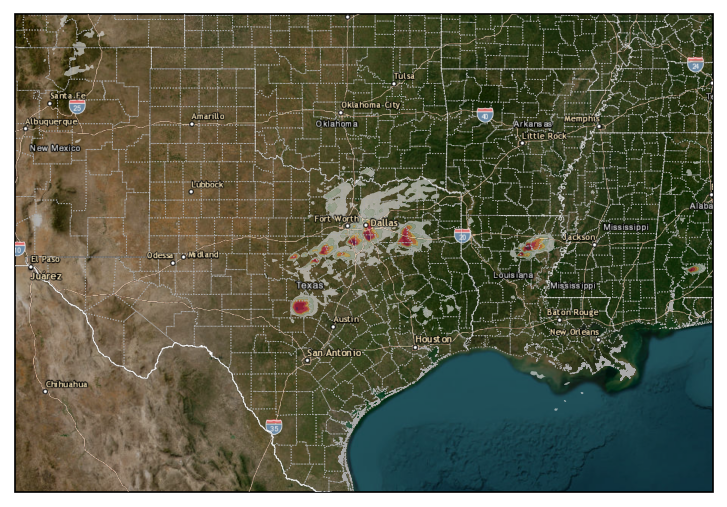

In [37]:
##### BLANK MAP FUNCTION ###############################################################################################
'''
Here is where you set up the domain.
Want to add another? Just copy the last (elif) one and change the bounds (try to keep it square)
Note the attributes are turned OFF on the cx.add_basemap layers IF you have mixed and matched provider sources. \
This is because each attribution goes on top of the other, and thus are manually added so they remain legible.
'''

def blankmap():
    global maplayertext1, maplayertext2, ax
    print('   > Initializing map')
    plt.figure(figsize=(6,5),frameon=True)
    F = plt.gcf()  # Gets the current figure

    ax = plt.axes(projection=proj)

    zoom = (cx.tile._calculate_zoom(west,
                                    south,
                                    east,
                                    north) - map_zoom_offset)

    ax.set_extent([west,
                  east,
                  south,
                  north], crs=latloncrs)

    ax.set_facecolor('black') #Darken the map background a bit
    print('   > Adding fancy map tiles')
    #ax.add_feature(cfeature.LAND, edgecolor='none', facecolor='#FAFAF8', zorder=-2)
    #cx.add_basemap(ax, source="https://services.arcgisonline.com/arcgis/rest/services/Elevation/World_Hillshade/MapServer/tile/{z}/{y}/{x}",
    #                attribution=False, crs=CRS.from_epsg(3857), zorder=-1)
    cx.add_basemap(ax, source="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
                    attribution=False, alpha=0.7, zorder=-1)
    maplayertext1 = "© Esri, Maxar, Earthstar Geographics, HERE, Garmin" #for MapTiler Hillshade
    #ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#b3bbbd', zorder=1) # adds fill over the ocean
    #ax.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#b3bbbd', zorder=1) # adds fill over lakes
    cx.add_basemap(ax, source="https://services.arcgisonline.com/arcgis/rest/services/Reference/World_Boundaries_and_Places/MapServer/tile/{z}/{y}/{x}",
                    attribution=False, zoom=zoom, zorder=25)
    cx.add_basemap(ax, source='https://services.arcgisonline.com/arcgis/rest/services/Reference/World_Transportation/MapServer/tile/{z}/{y}/{x}',
                   zoom=zoom, zorder=24)
    maplayertext2 = "© OpenStreetMap contributors, and the GIS user community"

    if cwa_opt:
      try:
        if os.path.exists("shp/w_05mr24.shp"):
          pass
        else:
          cwa_url = "https://www.weather.gov/source/gis/Shapefiles/County/c_05mr24.zip"
          cmd_mkshp = 'mkdir shp'
          os.system(cmd_mkshp)
          urlretrieve(cwa_url, "shp/nws_cwa_outlines.zip")
          cmd_uz = 'unzip shp/nws_cwa_outlines.zip -d shp'
          os.system(cmd_uz)
        cwa_feature = ShapelyFeature(Reader("shp/w_05mr24.shp").geometries(),ccrs.PlateCarree(), edgecolor='darkgrey', facecolor='none', linewidth=1.0, linestyle='solid')
        ax.add_feature(cwa_feature)
      except:
        print("Aw shucks, no CWA boundaries for you. Sorry bout that.")

    if county_opt:
      try:
        if os.path.exists("shp/c_05mr24.shp"):
          pass
        else:
          county_url = "https://www.weather.gov/source/gis/Shapefiles/County/c_05mr24.zip"
          try:
            cmd_mkshp = 'mkdir shp'
            os.system(cmd_mkshp)
          except:
            pass
          urlretrieve(county_url, "shp/nws_county_outlines.zip")
          cmd_uz2 = 'unzip shp/nws_county_outlines.zip -d shp'
          os.system(cmd_uz2)
        county_feature = ShapelyFeature(Reader("shp/c_05mr24.shp").geometries(),ccrs.PlateCarree(), edgecolor='darkgrey', facecolor='none', linewidth=0.5, linestyle=':')
        ax.add_feature(county_feature)
      except:
        print("Aw shucks, no county boundaries for you. Sorry bout that.")


###### FINAL DATA+LEGEND MAPPING ########################################################################################

def drawmap(DATA,TITLESTRING,PROD,UNITS,LEVS):
    F = plt.gcf()  # Gets the current figure
    ax = plt.gca()  # Gets the current axes

    if maplayertext1 != "":
      plt.text(0.005, -0.02, 'Map layers: %s // %s' % (maplayertext1,maplayertext2), transform = ax.transAxes,
               horizontalalignment='left',fontsize=4,color='k',style='italic',
               path_effects=[PathEffects.withStroke(linewidth=1.4,foreground='w')], zorder=99)

    # Let's put together a legend instead of an ugly colorbar
    print('   > Adding legend')
    proxy = [mpatches.Patch(color = pc.get_facecolor()[0]) for pc in DATA.collections]
    LLABS = []
    for i in range(0, len(LEVS)-1):
      label = str(LEVS[i])+"-"+str(LEVS[i+1])+UNITS
      LLABS.append(label)

    #proxy = proxy[::-1]
    #LLABS = LLABS[::-1]

    l = ax.legend(handles=proxy, labels=LLABS, fontsize=4,fancybox=False,
                  title=TITLESTRING, bbox_to_anchor =(0.5, 1.01), ncol=9, loc=8,
                  frameon=False)
    l.set_zorder(100)
    plt.setp(l.get_title(), multialignment='center', fontsize=6, weight='bold')

     # Now let's add an "inset" map (only outside the current map)
    print('   > Adding inset map')

    a = ax.get_position()
    inset_rect_ax = [0.01, 0.01]
    mytrans = ax.transAxes + ax.figure.transFigure.inverted()
    infig_position = mytrans.transform(inset_rect_ax)
    #print(f'a.height = {a.height} / a.width={a.width}')
    axins = F.add_axes([infig_position[0], infig_position[1], (a.height/4.), (a.height/4.)],
                       anchor='SE',projection=ccrs.PlateCarree())
    axins.set_aspect('1')
    axins.set_extent([-125.650, -66.008, 23.077, 51.924], crs=latloncrs)
    axins.add_feature(cfeature.NaturalEarthFeature(
                      'cultural', 'admin_1_states_provinces_lines', '50m',
                       edgecolor='black', facecolor='none', linewidth=0.2), zorder=0)
    axins.add_feature(cfeature.COASTLINE, linewidth=0.2,zorder=2)
    axins.add_feature(cfeature.BORDERS, linewidth=0.4, zorder=2)
    axins.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='#b3bbbd', zorder=1) # adds fill over the ocean
    axins.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#b3bbbd', zorder=1) # adds fill over lakes
    domain_outline = mpatches.Rectangle((west, south), (east - west), (north-south),
                                       fill=False,
                                       color='red',
                                       linewidth=0.5,
                                       zorder=2)
    axins.add_patch(domain_outline)
    for spine in axins.spines.values():
        spine.set_edgecolor('white')

    print('   > Finishing up and saving plot')

    if custom_name:
      custom_name_sanitized = custom_name.replace(" ","")
      file_id = 'MRMS_%s_%s_%s_%s' % (PROD,valid_duration_input, valid_date.strftime('%Y%m%d%H'), custom_name_sanitized)
    else:
      file_id = 'MRMS_%s_%s_%s_%s' % (PROD,valid_duration_input, valid_date.strftime('%Y%m%d%H'), dom)
    filename = '%s.png' % (file_id)
    plt.savefig(filename,bbox_inches='tight', facecolor="#FFFFFF") # Saves the figure with small margins
    print(f'   > Plot saved as {filename}')

    plt.show()

    def plot_ML_SVR():
        print("Making Severe Plot...")
    svr = csu_mlp.values
    blankmap()
    print('   > Contouring ML SVR')

    SVR_COLS = ["#dcdcdc", "#b9c9ba", "#f1c86a", "#ed7645", "#ce2754", "#a20435","#630157"]
    SVR_LEVS = [0.02, 0.05, 0.10, 0.15, 0.30, 0.45, 0.60, 1.00]
    SVR_LEVS = [0.52, 0.55, 0.58, 0.60, 0.61, 0.62, 0.65]
    SVR_LEVS = [20, 32, 42, 47, 52, 57, 62, 65]
    SVR_Text = ["2-5%", "5-10%", "10-15%", "15-30%", "30-45%", "45-60%", "60-100%"]
    SVR_Text = ["52-55%", "55-58%", "58-60%", "60-61%", "61-62%", "62-65%"]
    SVR_Text = ["20-32", "32-42", "42-47", "47-52", "52-57", "57-62", "62-65"]
    SWO = plt.contourf(lons,lats,svr,SVR_LEVS,colors=SVR_COLS,extend='neither',alpha=0.65, transform=latloncrs,antialiased = True)

    if lsr_opt:
      day_delta = int(day) - 1
      lsr_start = init_date + timedelta (days = day_delta, hours = 12)
      lsr_start = lsr_start.strftime('%Y-%m-%dT%H:%M')
      lsr_end = valid_date.strftime('%Y-%m-%dT%H:%M')
      lsr_url = "https://mesonet.agron.iastate.edu/cgi-bin/request/gis/lsr.py?wfo[]=ALL&sts="+lsr_start+"Z&ets="+lsr_end+"Z&fmt=csv"
      csv_name = "lsr_"+lsr_start+"_"+lsr_end+".csv"

      try:
        file_exists = os.path.exists(csv_name)
        if file_exists:
          print("   > LSRs file already exists")
        else:
          print("   > Grabbing LSRs")
          urlretrieve(lsr_url, csv_name)

        LSRs = pd.read_csv(csv_name, usecols= ['LAT','LON','MAG','TYPECODE','TYPETEXT'], on_bad_lines='skip')
        LSRs['MAG'] = LSRs.MAG.replace('None','0').astype(float)
        LSRs['LAT'] = LSRs.LAT.astype(float)
        LSRs['LON'] = LSRs.LON.astype(float)
        LSRs_hail = LSRs[(LSRs.TYPECODE == 'H') & (LSRs.MAG >= 1)]
        hail_lats= LSRs_hail['LAT'].to_numpy()
        hail_lons= LSRs_hail['LON'].to_numpy()
        LSRs_wind = LSRs[((LSRs.TYPECODE == 'G') & (LSRs.MAG >= 58)) | (LSRs.TYPECODE == 'D')]
        wind_lats= LSRs_wind['LAT'].to_numpy()
        wind_lons= LSRs_wind['LON'].to_numpy()
        LSRs_tor = LSRs[(LSRs.TYPECODE == 'T')]
        tor_lats= LSRs_tor['LAT'].to_numpy()
        tor_lons= LSRs_tor['LON'].to_numpy()
        print("     >> Plotting LSRs")
        if int(day) > 1:
          plt.scatter(hail_lons, hail_lats, marker=get_marker("\uf73b"), color="green", edgecolor='none', s=55,transform=latloncrs)
          plt.scatter(wind_lons, wind_lats, marker=get_marker("\uf72e"), color="blue", edgecolor='none', s=55,transform=latloncrs)
          plt.scatter(tor_lons, tor_lats, marker=get_marker("\uf76f"), color="tab:red", edgecolor='none', s=55,transform=latloncrs)
        elif severe_hazard == "WIND":
           plt.scatter(wind_lons, wind_lats, marker=get_marker("\uf72e"), color="blue", edgecolor='none', s=55,transform=latloncrs)
        elif severe_hazard == "HAIL":
          plt.scatter(hail_lons, hail_lats, marker=get_marker("\uf73b"), color="green", edgecolor='none', s=55,transform=latloncrs)
        elif severe_hazard == "TOR":
          plt.scatter(tor_lons, tor_lats, marker=get_marker("\uf76f"), color="tab:red", edgecolor='none', s=55,transform=latloncrs)

      except:
        print("     !> No LSRs for you")

    units = '%'
    title = ""
    if int(day) > 1:
      prodid = 'CSU_SVR_Day'+str(day)
    else:
      prodid = 'CSU_SVR_'+severe_hazard+'_Day'+str(day)

    drawmap(SWO, title, prodid, units, SVR_LEVS)

matplotlib.rcParams['figure.dpi'] = 150 # make high quality figure
if hazard == "ERO":
  plot_ML_ERO()
elif hazard == "Severe":
  plot_ML_SVR()
